In [1]:
import re
import operator
import matplotlib.pyplot as plt
import networkx as nx

from wordcloud import WordCloud
from visualization_methods import VisualizationMethods as vm
from aggregation_methods import AggregationMethods as am
import data_methods as dm

df = dm.get_valid_dataframe()
df = df[df['repo_last_modified'] >= '2021-01-01T00:00:00:000']

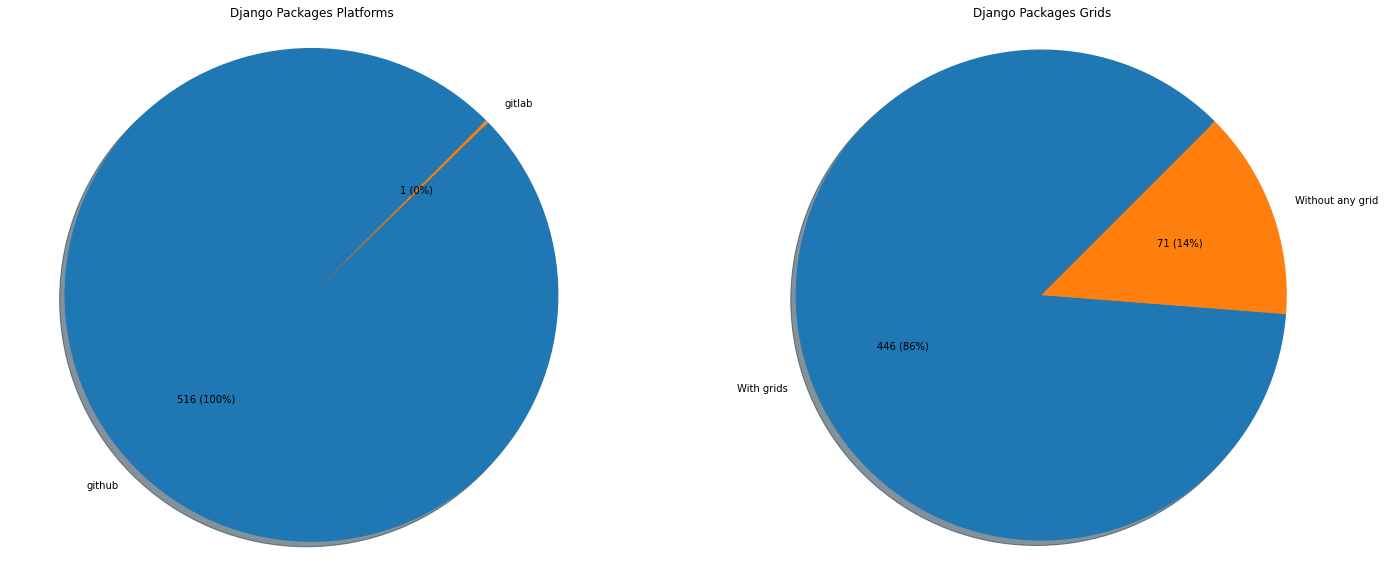

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.set_facecolor('white')

platforms = ('github', 'gitlab')

sizes = [
    len(df[df['platform'] == platforms[0]]),
    len(df[df['platform'] == platforms[1]]),    
]

vm.set_pie_by_ax(ax1, sizes, platforms, 'Django Packages Platforms')

sizes = [
    len(df[~df['dp_grids'].isnull()]),
    len(df[df['dp_grids'].isnull()]),
]

vm.set_pie_by_ax(ax2, sizes, ('With grids', 'Without any grid'), 'Django Packages Grids')

plt.show()

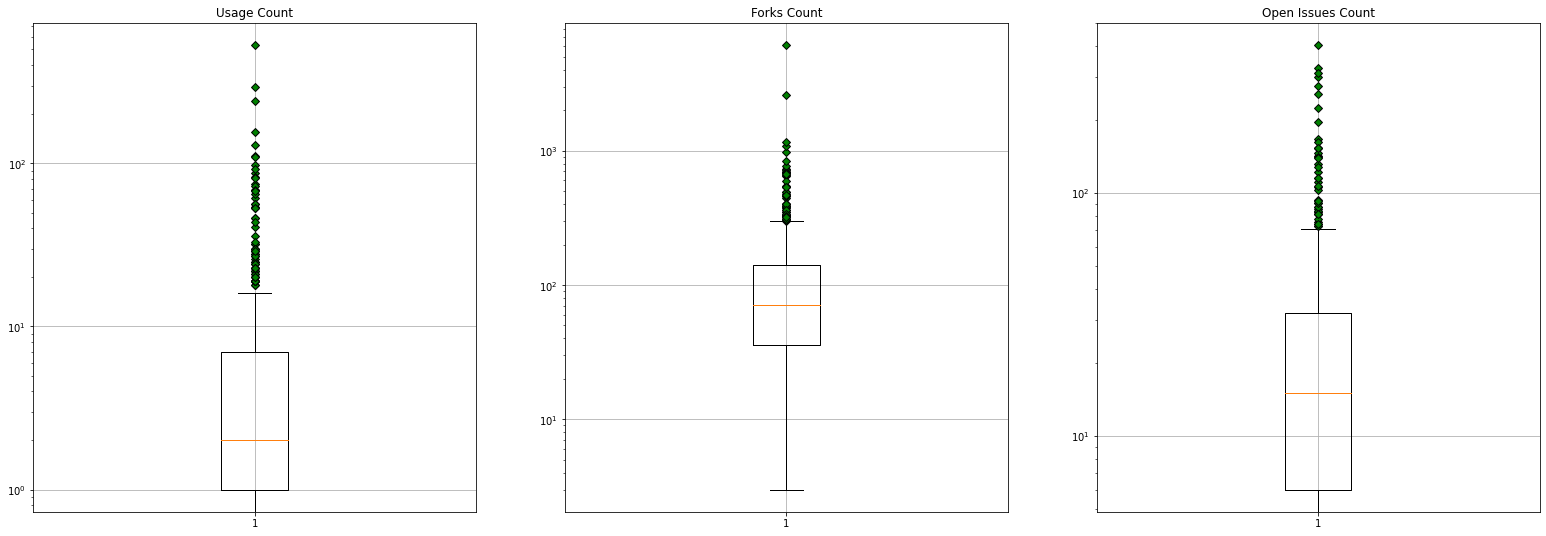

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27, 9))

vm.set_boxplot_by_ax(ax1, df['dp_usage_count'].values, 'Usage Count', True)
vm.set_boxplot_by_ax(ax2, df['repo_forks'].values, 'Forks Count', True)
vm.set_boxplot_by_ax(ax3, df['repo_open_issues'].values, 'Open Issues Count', True)

plt.show()

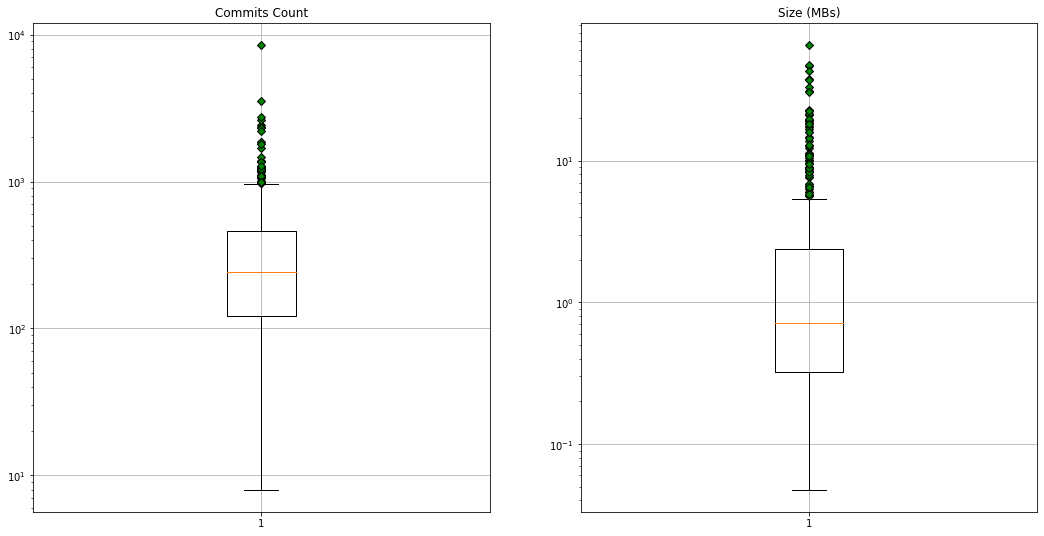

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

size_bytes = df['repo_size'].values
size_kbytes = [b/1000 for b in size_bytes]
size_mbytes = [b/1000 for b in size_kbytes]

vm.set_boxplot_by_ax(ax1, df['repo_commits'].values, 'Commits Count', True)
vm.set_boxplot_by_ax(ax2, size_mbytes, 'Size (MBs)', True)

plt.show()

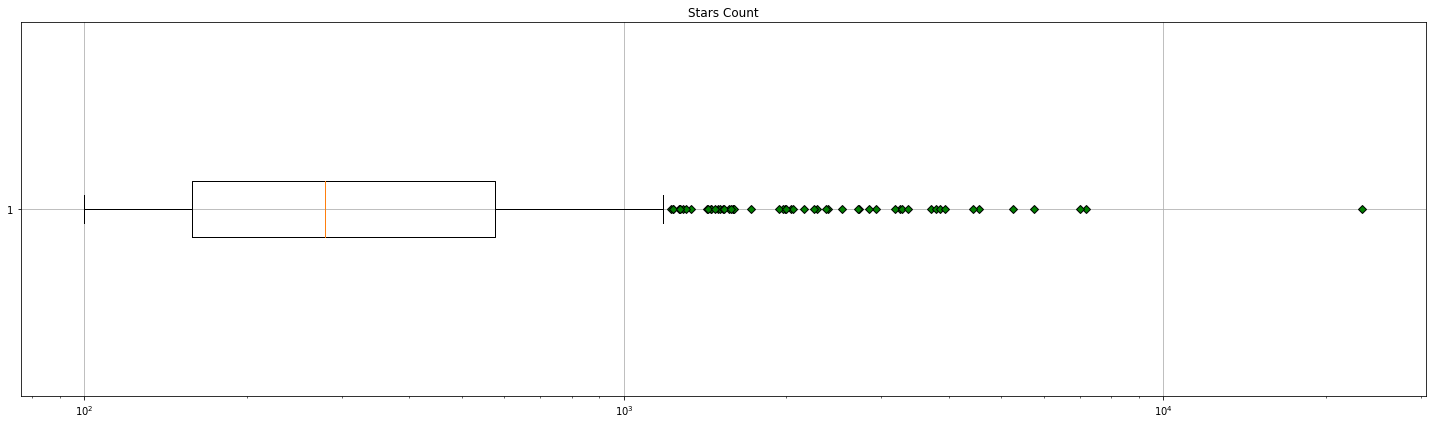

In [5]:
fig, ax = plt.subplots(figsize=(20, 6))

vm.set_boxplot_by_ax(ax, df['repo_stars'].values, 'Stars Count', True, True)

plt.tight_layout()
plt.show()

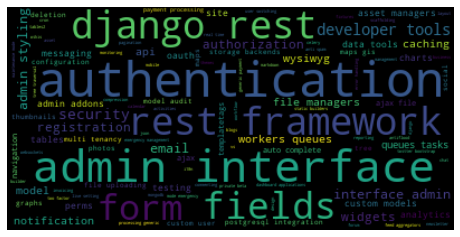

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
fig.set_facecolor('white')

grid_concate, grids_freq = am.get_concate_and_freq(df[~df['dp_grids'].isnull()]['dp_grids'].values)

ax.imshow(WordCloud().generate(grid_concate), interpolation='bilinear')
ax.axis("off")

plt.show()

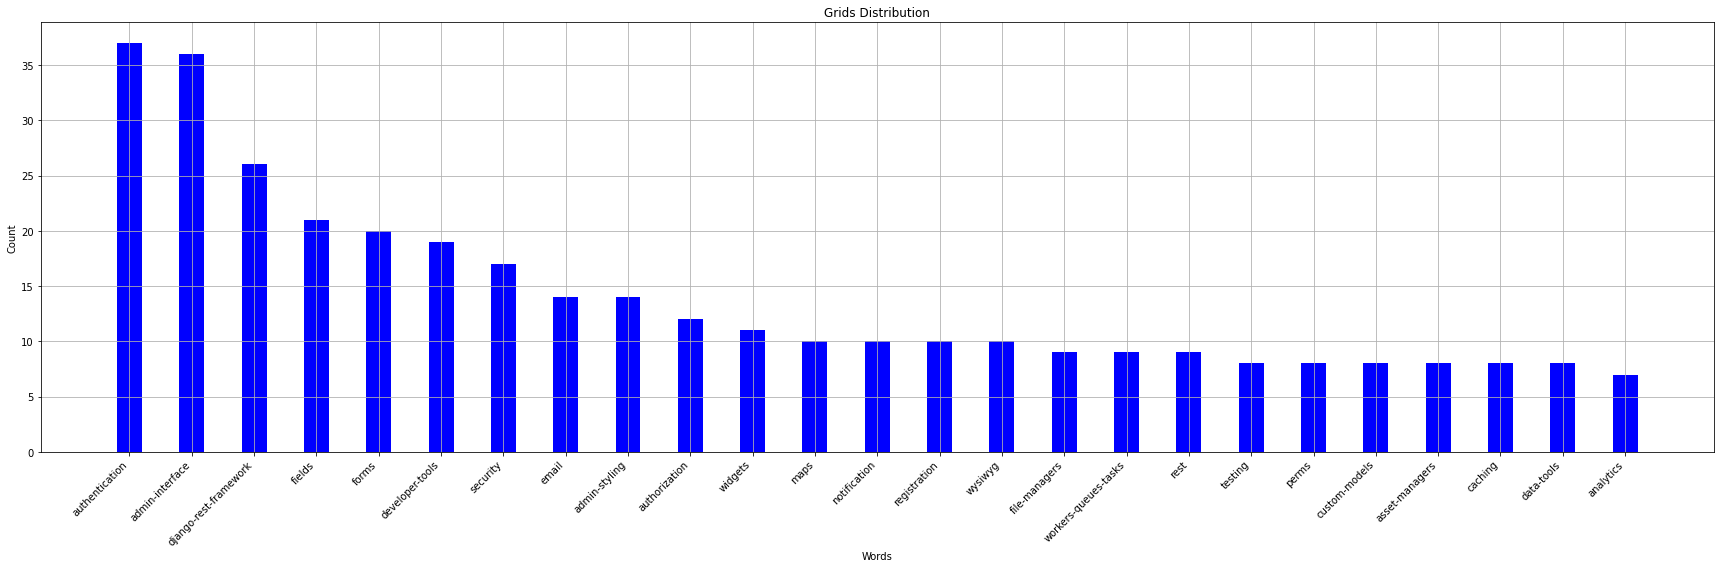

In [7]:
top = 25
top_grid_freq = {k[0]: k[1] for k in sorted(grids_freq.items(), key=operator.itemgetter(1), reverse=True)[:top]}

vm.show_bar_chart_by_dict(top_grid_freq, 'Words', 'Count', 'Grids Distribution', 'blue')

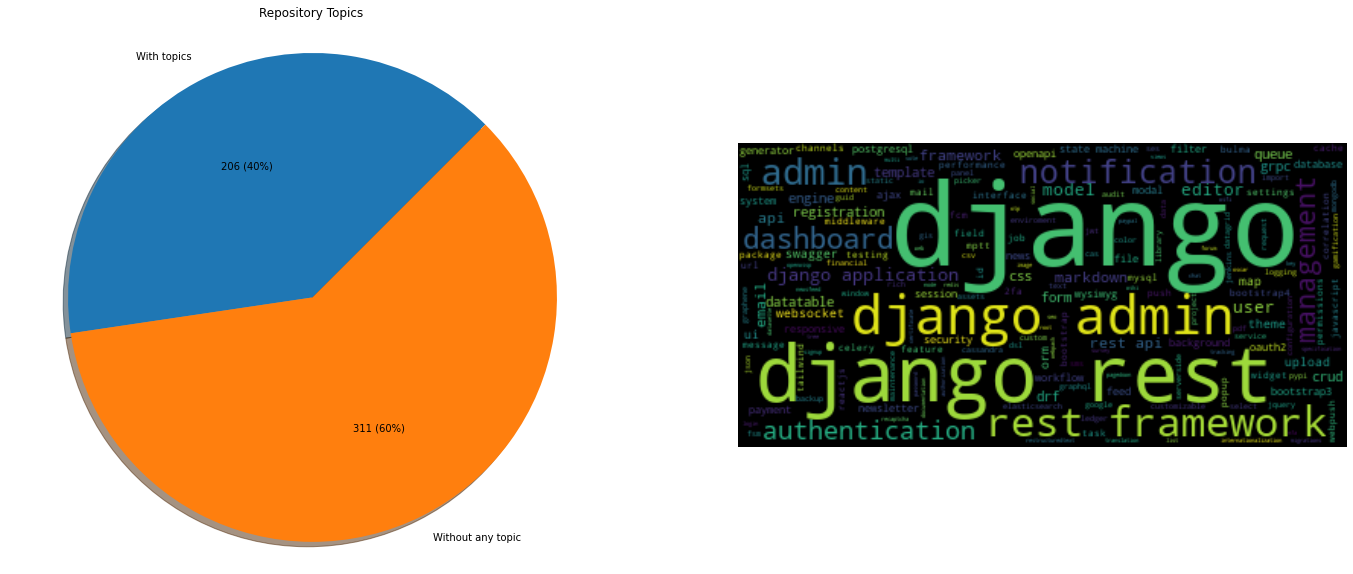

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.set_facecolor('white')

labels = 'With topics', 'Without any topic'

sizes = [
    len(df[~df['repo_topics'].isnull()]),
    len(df[df['repo_topics'].isnull()]),
]

vm.set_pie_by_ax(ax1, sizes, labels, 'Repository Topics')

unwanted_topics = [ 'django', 'python' ]
unwanted_regex = [ 
    re.compile(r'^(django)((\d+)|(\-\d+)|\Z)', re.IGNORECASE), 
    re.compile(r'^(python)((\d+)|(\-.*)|\Z)', re.IGNORECASE), 
    re.compile(r'^(hacktoberfest)((\-\d+)|(\d+)|\Z)', re.IGNORECASE)
]

topics_concate, topics_freq = am.get_concate_and_freq(
    df[~df['repo_topics'].isnull()]['repo_topics'].values, 
    unwanted_topics, 
    unwanted_regex
)

ax2.imshow(WordCloud().generate(topics_concate), interpolation='bilinear')
ax2.axis("off")

plt.show()

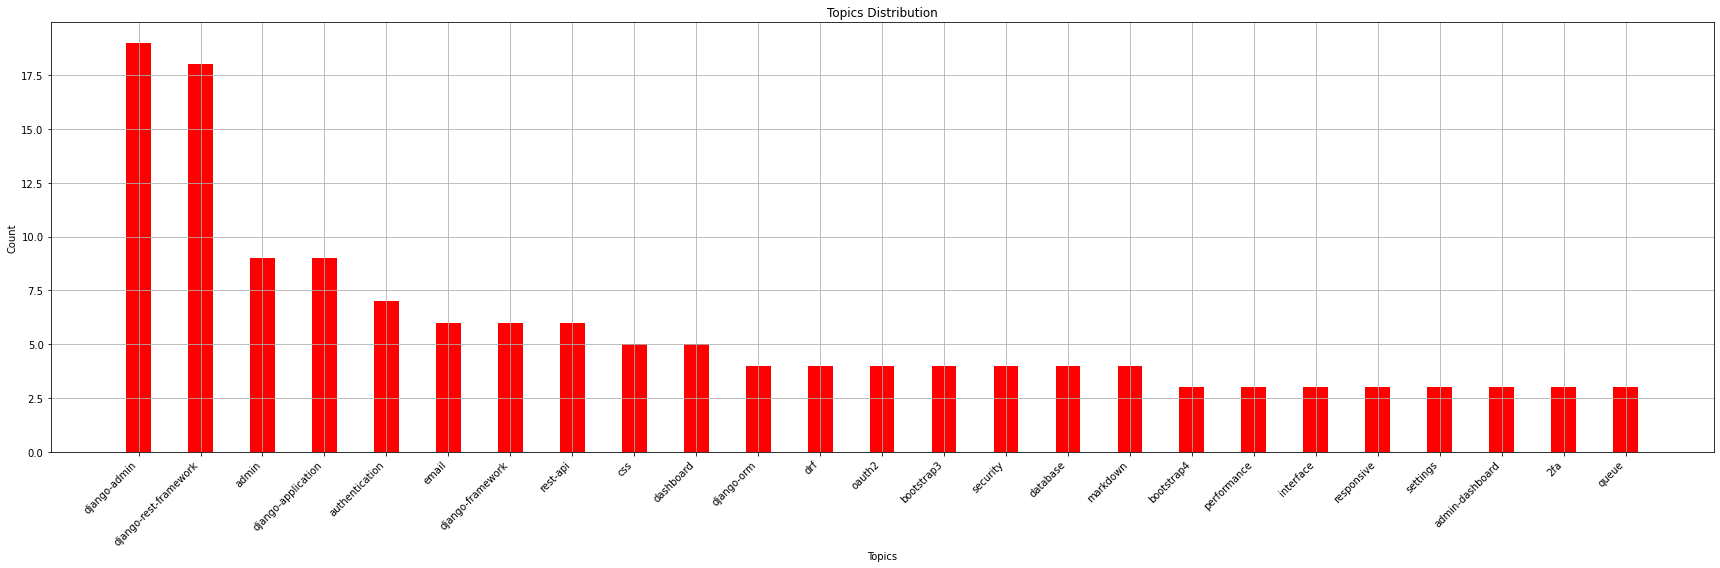

In [9]:
top = 25
top_repo_freq = {k[0]: k[1] for k in sorted(topics_freq.items(), key=operator.itemgetter(1), reverse=True)[:top]}

vm.show_bar_chart_by_dict(top_repo_freq, 'Topics', 'Count', 'Topics Distribution', 'red')

In [10]:
graph = dm.get_authors_graph()
top_grids = ['authentication', 'admin-interface', 'django-rest-framework', 'fields', 'forms', 'developer-tools']
subgraphs = {}

for top_grid in top_grids:
    nodes = [n for n,v in graph.nodes(data=True) if top_grid in v['grids']]  
    subgraph = graph.subgraph(nodes)
    subgraphs[top_grid] = subgraph

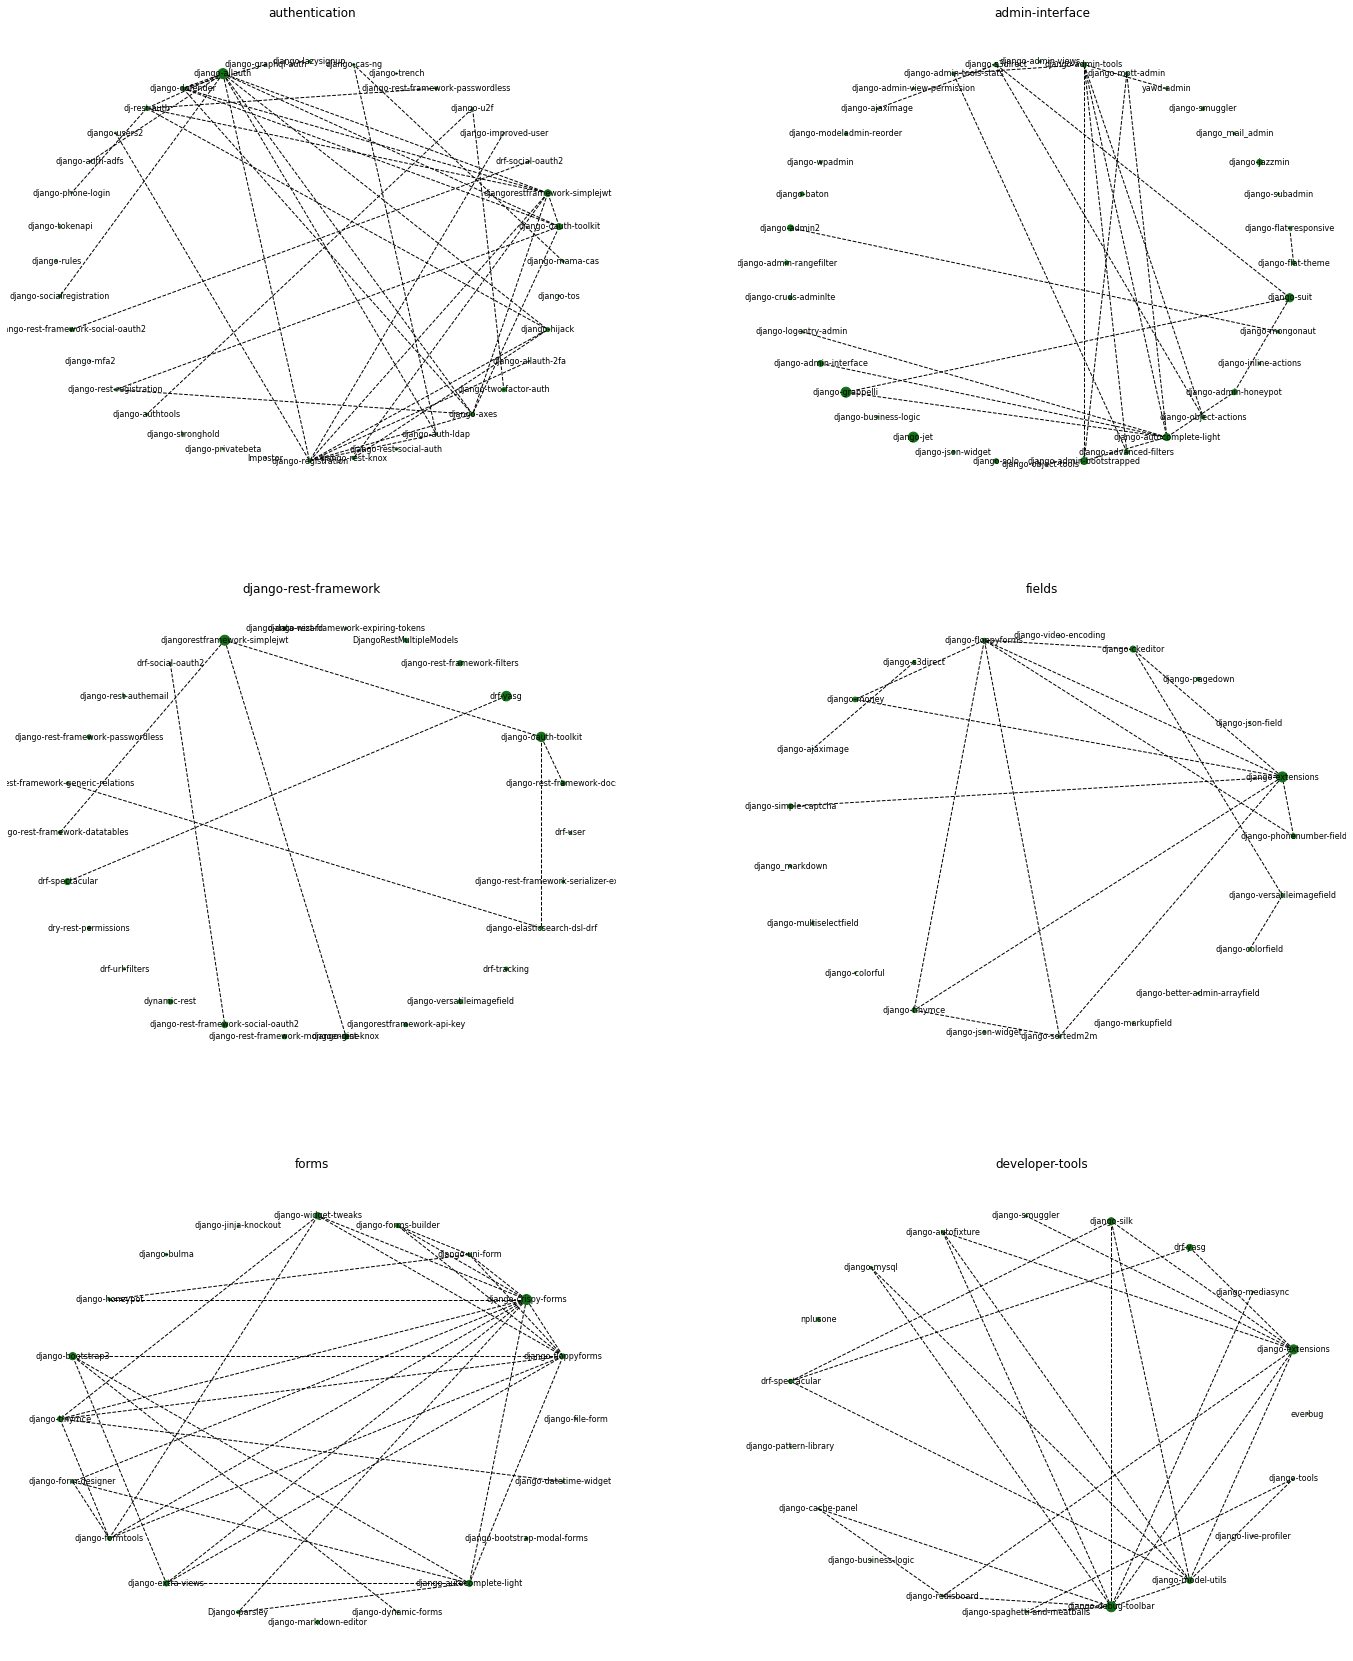

In [11]:
fig, (row1, row2, row3) = plt.subplots(3, 2, figsize=(24, 30))
axs = [row1[0], row1[1], row2[0], row2[1], row3[0], row3[1]]
current_axs_index = 0
max_size_node = 100

options = {
    'node_color': '#117016',
    'edge_color': '#000000',
    'font_size': 8,
    'style': 'dashed',
    'with_labels': True,
    'width': 1,
}

for grid, subgraph in subgraphs.items():
    pos = nx.circular_layout(subgraph)
    ax = axs[current_axs_index]
    ax.set_title(grid)

    stars = [subgraph.nodes.get(n)['stars'] for n in subgraph.nodes]
    authors = [subgraph.nodes.get(n)['authors'] for n in subgraph.nodes]
    max_stars = max(stars)
    max_authors = max(authors)
    sizes = [(stars[i]*authors[i])/((max_stars*max_authors)/max_size_node) for i in range(len(stars))]
    sizes = [star/(max_stars/max_size_node) for star in stars]

    nx.draw(subgraph, ax=ax, node_size=sizes, label=grid, pos=pos, **options)
    current_axs_index = current_axs_index + 1
